In [ ]:
import warnings
import numpy as np
import pandas as pd

import spectral
import pysptools
from spectral import *
from matplotlib import pyplot as plt
import numpy as np
from scipy import signal, interpolate, stats
from scipy.interpolate import interp1d
from scipy.signal import find_peaks, find_peaks_cwt


# Suppress pandas warnings
warnings.filterwarnings('ignore')

# Settings

do_plots = True

Current data is shaped: (1250, 100, 514)


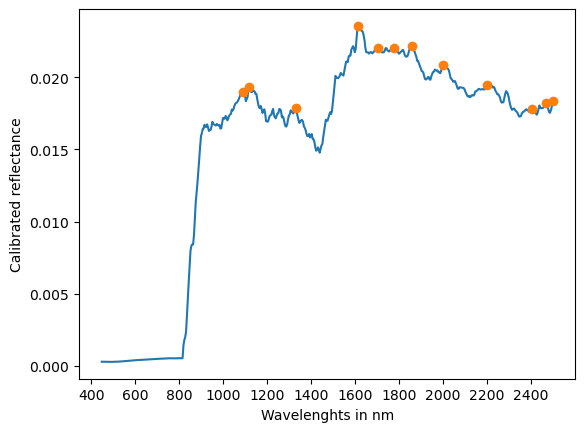

In [366]:
# Load some data
header = envi.read_envi_header('spectra/JA0464_18423_0001_20190207135542_00.procSpecRefl.hdr')
# img = open_image('spectra/JA0464_18423_0001_20190207135542_00.procProf3d.hdr')
                 # image = 'spectra/JA0464_18423_0001_20190207135542_00.procProf3d.bin')
curr_data = envi.open('spectra/JA0464_18423_0001_20190207135542_00.procSpecRefl.hdr', image = 'spectra/JA0464_18423_0001_20190207135542_00.procSpecRefl.bin')

curr_data_array = curr_data.asarray()
print(f"Current data is shaped: {curr_data_array.shape}")

# Let's get the wavelengths in a format we can use
wav_list = [val[0:-2] for val in header['band names']]
wav_array = np.asarray(wav_list).astype(float)

# and the units
wav_unit = header['wavelength units']
n_bands = header['bands']

# Set the pixel we want for now

curr_x = 100
curr_y = 54

if do_plots:

    curr_pixel = curr_data_array[curr_x, curr_y, :]
    plt.plot(wav_array, curr_pixel)
    plt.xlabel('Wavelenghts in ' + wav_unit)
    plt.ylabel('Calibrated reflectance')
    plt.xticks(np.arange(400,2500, step = 200))
    
    # Get the peaks of the current spectrum
    peaks = find_peaks(curr_pixel,
                       width = 5)[0]
    # Append the end of the spectrum
    peaks = np.append(peaks, curr_pixel.shape[0]-1)
    
    plt.plot(wav_array[peaks], curr_pixel[peaks], 'o')

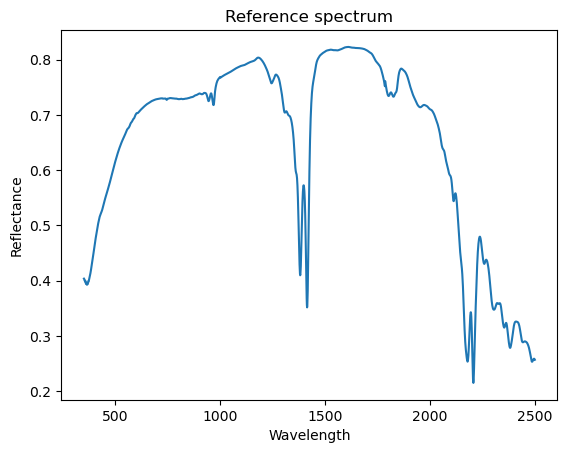

In [383]:
# Load a reference for testing
curr_ref = pd.read_csv('reference_lib/1004_NMC068171_Dickite_Data_clean.csv', header = None)
curr_ref.columns = ['Wavelength', 'Reflectance']
if do_plots:
    plt.plot(curr_ref['Wavelength'], curr_ref['Reflectance'])
    plt.title('Reference spectrum')
    plt.xlabel('Wavelength')
    plt.ylabel('Reflectance')

In [344]:
# Functions

def extract_all_sheets(file_path):
    excel_file = pd.ExcelFile(file_path)
    sheet_names = excel_file.sheet_names
    
    all_data = [excel_file.parse(sheet_name, header = None) for sheet_name in sheet_names]
    
    return all_data

def get_spreadsheet_coords(df, label):
    """
    Accepets either a single label or a list
    """
    if type(label) is str:
        x_ind, y_ind = np.where(mineral_df == label)
        return x_ind[0], y_ind[0]

    elif type(label) is list:
        x_ind = []
        y_ind = []
        for list_val in label:
            x, y = np.where(mineral_df == list_val)
            x_ind.append(x[0])
            y_ind.append(y[0])
        return np.asarray(x_ind), np.asarray(y_ind)


def get_val_list(df,
                 val_name):
    # Identify how many features we have here
    start_x, start_y = get_spreadsheet_coords(df, val_name)
    val_list = []
    for i in range(start_x +1, df.shape[0]):
        curr_val = df.iloc[i , start_y]
        if i >= df.shape[0]:
            break
        elif not pd.isna(curr_val):
            val_list.append(curr_val)
        else:
            break
    
    print(f"Found {len(val_list)}: {val_list}")
    return val_list

def get_mask_from_waves(wav_array, wav_min, wav_max):
   return (wav_array >= wav_min) * (wav_array <= wav_max)

def generate_linear_regression(X, Y):
    # Calculate the slope and intercept for the linear regression
    slope = (Y[-1] - Y[0]) / (X[-1] - X[0])
    intercept = Y[0] - slope * X[0]

    # Generate x values between the first and final points
    x_values = np.linspace(X[0], X[-1], num=len(X))

    # Generate y values using the linear regression equation
    y_values = slope * x_values + intercept

    return x_values, y_values

In [197]:
# Let's start by ingesting the criteria we've gotten from Cari
ref_lib_data = extract_all_sheets('Ref Library match criteria v1.xlsx')
ref_lib_data[1]

,0,1,2,3,4,5,6,7,8,9,10,11
0,Mineral,Amphibole,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Feature Check,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Feature #,Include/Exclude,L min,L max,Wmin,Wmax,Hmin%,Hmax%,ASmin,ASmax,Smooth?,Weight
4,F-2300,include,2300,2335,15,250,3,100,NaN,NaN,low,3
5,F-2380,include,2385,2425,15,250,3,100,NaN,NaN,low,3
6,F-2250,exclude,2230,2255,5,125,5,50,NaN,NaN,low,1
7,other,exclude,2070,2100,5,100,5,25,NaN,NaN,low,1
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [404]:
# def parse_mineral_sheet(mineral_df):

mineral_df = ref_lib_data[4]
mineral_x, mineral_y = get_spreadsheet_coords(mineral_df, 'Mineral')

# Identify which mineral we're parsing
curr_mineral = mineral_df.iloc[mineral_x, mineral_y+1]
print(f"Current mineral: {curr_mineral}")

feature_list = get_val_list(mineral_df,
                            'Feature #')

# Do the same thing for shapes
region_list = get_val_list(mineral_df,
                            'Region #')

# Note that this matches wrong for sheet 1 right now. 
# we'll need to double check at a later stage of parsing
# whether the rows have proper values or not, should be easy
# using pd.isna

# Do the same thing for shapes
criteria_list = get_val_list(mineral_df,
                            'Criteria #')

# Do the same thing for final weights
overall_list = get_val_list(mineral_df,
                            'Overall weighting')

Current mineral: Dickite
Found 3: ['F-1400', 'F-1400', 'F-2200']
Found 4: [1, 2, 3, 4]
Found 8: [1, 2, 3, 4, 5, 6, 7, 8]
Found 3: ['Features', 'Shape', 'Band Math']


In [ ]:
# Retrieve features to include
fx,fy = get_spreadsheet_coords(mineral_df, feature_list)

feature_subset_df = mineral_df.iloc[fx, :]
incl_features_df = feature_subset_df[feature_subset_df[1] == 'include']
excl_features_df = feature_subset_df[feature_subset_df[1] == 'exclude']

# for incl_feature in range(incl_features_df.shape[0]):
incl_feature = 0
curr_feature = (incl_features_df.iloc[incl_feature, :])

curr_l_min = curr_feature[2]
curr_l_max = curr_feature[3]

curr_wav_mask = get_mask_from_waves(wav_array,
                           curr_l_min,
                           curr_l_max)

curr_x = wav_array[curr_wav_mask]
curr_y = curr_pixel[curr_wav_mask]

# Generate the linear regression line
x_values, y_values = generate_linear_regression(curr_x, curr_y)

# Generate the continuum removed version
curr_y_hull_ratio = curr_y/y_values


if do_plots:
    # Plot the original data points
    plt.scatter(curr_x, curr_y, color='red', label='Original feature')
    
    # Plot the linear regression line
    plt.plot(x_values, y_values, color='blue', label='Linear Regression')
    
    # Set labels and title
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Linear Regression')
    
    # Add a legend
    plt.legend()
    
    # Show the plot
    plt.show()
    
    # Generate the same number of points on the linear regression line
    generated_points = list(zip(x_values, y_values))
    
    plt.figure()
    
    plt.plot(curr_x, curr_y_hull_ratio, 'o-', label = 'Extracted feature')
    plt.legend()

# Do the same thing for the reference data

curr_ref_wav_mask = get_mask_from_waves(curr_ref.Wavelength,
                           curr_l_min,
                           curr_l_max)

curr_ref_x = curr_ref.Wavelength[curr_ref_wav_mask]
curr_ref_y = curr_ref.Reflectance[curr_ref_wav_mask]


# Generate the linear regression line
x_ref_values, y_ref_values = generate_linear_regression(curr_ref_x.values, 
                                                        curr_ref_y.values)

# Generate the continuum removed version
curr_ref_y_hull_ratio = curr_ref_y/y_ref_values


if do_plots:
    plt.figure()
    # Plot the original data points
    plt.scatter(curr_ref_x, curr_ref_y,
                color='red', label='Original feature')
    
    # Plot the linear regression line
    plt.plot(x_ref_values, y_ref_values,
             color='blue', label='Linear Regression')
    
    # Set labels and title
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Linear Regression')
    
    # Add a legend
    plt.legend()
    
    # Show the plot
    plt.show()
    
    # Generate the same number of points on the linear regression line
    generated_points = list(zip(x_ref_values, y_ref_values))
    
    plt.figure()
    
    plt.plot(curr_ref_x, curr_ref_y_hull_ratio, 'o-', label = 'Extracted feature')
    plt.legend()

In [400]:
# Now we have two spectra in a region to compare, but we can't do that unless they have the same 
# number of points

new_length = len(curr_y_hull_ratio)

curr_ref_y_hull_ratio_downsampled = np.interp(np.linspace(0, len(curr_ref_y_hull_ratio) - 1, new_length),
                                    np.arange(len(curr_ref_y_hull_ratio)), curr_ref_y_hull_ratio)


In [402]:
def perform_least_squares_fit(Lc, Oc):
    n = len(Lc)

    # Calculate the necessary summations
    sigma_Oc = np.sum(Oc)
    sigma_Lc = np.sum(Lc)
    sigma_OcLc = np.sum(Oc * Lc)
    sigma_Oc_sq = np.sum(Oc**2)
    sigma_Lc_sq = np.sum(Lc**2)

    # Calculate the coefficients 'a' and 'b'
    a = (sigma_Oc - (sigma_Lc / n)) / n
    b = (sigma_OcLc - (sigma_Oc * sigma_Lc) / n) / (sigma_Lc_sq - (sigma_Lc**2) / n)

    # Calculate 'k' and 'F'
    k = a / (1 - a)
    b_prime = (sigma_OcLc - (sigma_Oc * sigma_Lc) / n) / (sigma_Oc_sq - (sigma_Oc**2) / n)
    F = np.sqrt(b * b_prime)

    return a, b, k, F

# Example usage
Lc = curr_y_hull_ratio
Oc = curr_ref_y_hull_ratio_downsampled

a, b, k, F = perform_least_squares_fit(Lc, Oc)

print("a:", a)
print("b:", b)
print("k:", k)
print("F:", F)



a: 0.8916940656405996
b: -0.008300094269276916
k: 8.233104408495462
F: 0.010225697086724505


Three parameters for each spectrum are computed: weighted fit, Fw, weighted depth, Dw, and weighted fit times depth (fit x depth), FDw. They are computed by weighting the relative areas of the absorption features *of the reference library spectrum*:


<b>Weighted fit</b>
- Fw = sigma(ciFi)
  
<b>Weighted depth</b>
- Dw = sigma(ciDi)
  
<b>Weighted fit x depth </b>
- FDw = sigma(ciFiDi)

where ‘‘i’’ is the feature number, *ci is the relative fractional area of library reference features between each feature and its continuum*:

sigma(ci) = 1.0

Fi, Di are the fits (the correlation coefficients) and depths of the corresponding features. The feature depths and relative areas are calculated from the fitted library reference features. The relative area is found by *integration of the continuum-removed feature (the area between the feature curve and 1.0) divided by the sum of the areas of all features analyzed for each reference material*. Consider an observed spectrum with weak absorption features. The calculation of the areas of these features may be dominated by noise and could lead to bias in the decision process. Thus the areas are computed from the library reference spectra. This is also a computational advantage because they are computed only once and then used in tests against multiple unknown spectra.